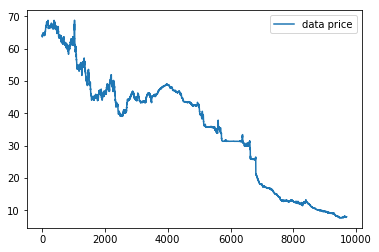

In [16]:
# Data: time-serie data from smartwatch or smartwatch data
# %matplotlib inline # for plt.show()
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Data reading
# The smartwatch historical/time-seris data to visualize
# data_path = 'data/smartwatch_data/experimental_data_analysis/Basis_Watch_Data.csv'
data_path = 'data/financial_data/USD_INR.csv'
data = pd.read_csv(data_path)

# # Data: cleaning
# # Getting rid of NaN
# data = data.fillna(value=0.0)

# # # # Plotting the smartwatch data before scaling/batch normalization
# # data[:10000]['Price'].plot() #x='dteday', y='cnt'
# data[:3].plot()
# plt.legend()
# plt.show()

# # # data[:100].plot()
# np.array(data).shape, np.array(data).dtype, np.array(data, dtype=None).dtype, 
# np.array(data[:, 1:], dtype=None).dtype

data_price = np.array(data['Price'], dtype=float)
# data_price = np.array(data)
data_price.shape, data_price.dtype

plt.plot(data_price, label='data price')
plt.legend()
plt.show()

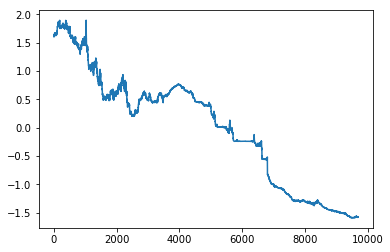

(4.6895674011185329e-17, 1.0, 1.0, (9697,), dtype('float64'))

In [17]:
# test_data = np.array([[1, 2, 3]], dtype=float)
# test_data.shape, test_data.dtype
# np.mean(test_data, axis=0), test_data

# data_ = np.array(data[:, 1], dtype=float)
# data_.shape, data_.dtype
data_mean = np.mean(data_price, axis=0)
data_std = np.std(data_price, axis=0)
# std, mean, np.sqrt(np.var(data_price))
# data_norm = (data_price - mean) / std
# data_norm.dtype, data_norm.shape

# plt.plot(data_norm, label='data price norm')
# # plt.plot(data_price[:10000], label='data price')
# plt.legend()
# plt.show()

data_price_norm = (data_price - data_mean) / data_std
plt.plot(data_price_norm)
plt.show()
data_price_norm.mean(), data_price_norm.std(), data_price_norm.var(), data_price_norm.shape, data_price_norm.dtype

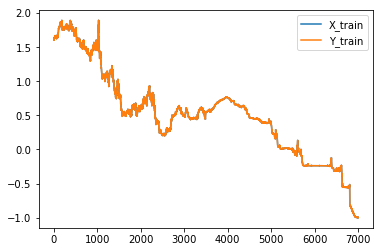

In [18]:
train_data = data_price_norm[:7000]
test_data = data_price_norm[7000:]
train_data.shape, test_data.shape
X_train = train_data[0:6999]
Y_train = train_data[1:7000]
X_train.shape, Y_train.shape

plt.plot(X_train, label='X_train')
plt.plot(Y_train, label='Y_train')
plt.legend()
plt.show()

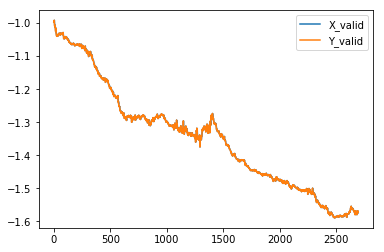

In [19]:
X_valid = test_data[0:2696] 
Y_valid = test_data[1:2697]
X_valid.shape, Y_valid.shape
plt.plot(X_valid, label='X_valid')
plt.plot(Y_valid, label='Y_valid')
plt.legend()
plt.show()

In [22]:
# Model or Network
import impl.layer as l
from impl.loss import *

class GRU:
    def __init__(self, D, H):
        self.D = D
        self.H = H
        self.losses = {'train':[], 'smooth train':[], 'valid': []}
        
        # Model params
        Z = H + D
        m = dict(
            Wz=np.random.randn(Z, H) / np.sqrt(Z / 2.),
            Wr=np.random.randn(Z, H) / np.sqrt(Z / 2.),
            Wh=np.random.randn(Z, H) / np.sqrt(Z / 2.),
            Wy=np.random.randn(H, D) / np.sqrt(H / 2.),
            bz=np.zeros((1, H)),
            br=np.zeros((1, H)),
            bh=np.zeros((1, H)),
            by=np.zeros((1, D))
        )
        self.model = m
        
    def initial_state(self):
        return np.zeros((1, self.H))

    def forward(self, X, h, m):
        Wz, Wr, Wh, Wy = m['Wz'], m['Wr'], m['Wh'], m['Wy']
        bz, br, bh, by = m['bz'], m['br'], m['bh'], m['by']

        X_in = X.copy()
        h_in = h.copy()

        X = np.column_stack((h_in, X_in))

        hz, hz_cache = l.fc_forward(X, Wz, bz)
        hz, hz_sigm_cache = l.sigmoid_forward(hz)

        hr, hr_cache = l.fc_forward(X, Wr, br)
        hr, hr_sigm_cache = l.sigmoid_forward(hr)

        X = np.column_stack((hr * h_in, X_in))
        
        hh, hh_cache = l.fc_forward(X, Wh, bh)
        hh, hh_tanh_cache = l.tanh_forward(hh)

        # h = (1. - hz) * h_old + hz * hh
        # or
        h = ((1. - hz) * h_in) + (hz * hh)
        # or
        # h = h_in + hz (hh - h_in)

        y, y_cache = l.fc_forward(h, Wy, by)
        
        cache = (h_in, hz, hz_cache, hz_sigm_cache, hr, hr_cache, hr_sigm_cache, hh, hh_cache, hh_tanh_cache, 
                 y_cache)

        return y, h, cache

    def backward(self, dy, dh, cache):
        h_in, hz, hz_cache, hz_sigm_cache, hr, hr_cache, hr_sigm_cache, hh, hh_cache, hh_tanh_cache, y_cache = cache
        
        dh_out = dh.copy()

        dh, dWy, dby = l.fc_backward(dy, y_cache)
        dh += dh_out

        dh_in1 = (1. - hz) * dh
        dhh = hz * dh
        dhz = (hh * dh) - (h_in * dh)
        # or
        # dhz = (hh - h_in) * dh

        dhh = l.tanh_backward(dhh, hh_tanh_cache)
        dXh, dWh, dbh = l.fc_backward(dhh, hh_cache)

        dh = dXh[:, :self.H]
        dX_in2 = dXh[:, self.H:]
        dh_in2 = hr * dh

        dhr = h_in * dh
        dhr = l.sigmoid_backward(dhr, hr_sigm_cache)
        dXr, dWr, dbr = l.fc_backward(dhr, hr_cache)

        dhz = l.sigmoid_backward(dhz, hz_sigm_cache)
        dXz, dWz, dbz = l.fc_backward(dhz, hz_cache)

        dX = dXr + dXz
        dh_in3 = dX[:, :self.H]
        dX_in1 = dX[:, self.H:]

        dh = dh_in1 + dh_in2 + dh_in3
        dX = dX_in1 + dX_in2

        grad = dict(Wz=dWz, Wr=dWr, Wh=dWh, Wy=dWy, bz=dbz, br=dbr, bh=dbh, by=dby)
        
        return dX, dh, grad

    def train_forward(self, X_train, h):
        ys, caches = [], []

        for X in X_train:
            X = X.reshape(1, -1) # X_1xn
            y, h, cache = self.forward(X, h, self.model)
            caches.append(cache)
            ys.append(y)
        
        ys = np.array(ys, dtype=float).reshape(len(ys), -1) # ys_txn instead of ys_tx1xn
        
        return ys, caches
                                
    def loss_function(self, y_pred, y_train): # , alpha alpha: learning rate
        loss, dys = 0.0, []

        for y, Y in zip(y_pred, y_train):
            #             loss += l2_regression(y_pred=y, y_train=Y)
            #             dy = dl2_regression(y_pred=y, y_train=Y)
            loss += l2_regression_reg(model=self.model, y_pred=y, y_train=Y) #, lam=alpha
            dy = dl2_regression_reg(y_pred=y, y_train=Y)
            #             loss += l1_regression_reg(model=self.model, y_pred=y, y_train=Y) #, lam=alpha
            #             dy = dl1_regression_reg(y_pred=y, y_train=Y)
            dys.append(dy)
            
        return loss, dys
    
    def train_backward(self, dys, caches):
        dh=(np.zeros((1, self.H)))
        grad=({key: np.zeros_like(val) for key, val in self.model.items()})
        grads=({key: np.zeros_like(val) for key, val in self.model.items()})

        for t in reversed(range(len(dys))):
            dy = dys[t].reshape(1, -1) # dy_1xn
            dX, dh, grad = self.backward(dy, dh, caches[t])
            for key in grad.keys():
                grads[key] += grad[key]
                
        return grads
    
    def test(self, X_seed, h, size):
        ys = []
        X = X_seed.reshape(1, -1)
        for _ in range(size):
            y, h, _ = self.forward(X, h, self.model)
            X = y.copy() # previous out for the next input for prediction
            ys.append(y) # list array
        
        ys = np.array(ys, dtype=float).reshape(len(ys), -1) # ys_txn instead of ys_tx1xn
        return ys

In [23]:
def get_minibatch(X, y, minibatch_size, shuffle):
    minibatches = []

    for i in range(0, X.shape[0], minibatch_size):
    # for i in range(0, X.shape[0] - minibatch_size + 1, 1):
        X_mini = X[i:i + minibatch_size]
        y_mini = y[i:i + minibatch_size]
        minibatches.append((X_mini, y_mini))

    return minibatches

def adam_rnn(nn, XY_train, alpha, mb_size, n_iter, print_after, XY_valid):
    X_train, y_train = XY_train
    X_valid, y_valid = XY_valid

    M=({key: np.zeros_like(val) for key, val in nn.model.items()})
    R=({key: np.zeros_like(val) for key, val in nn.model.items()})
        
    beta1 = .99
    beta2 = .999
    state = nn.initial_state()
    smooth_loss = 1.
    minibatches = get_minibatch(X_train, y_train, mb_size, shuffle=False)
    
    for iter in range(1, n_iter + 1):
        for idx in range(len(minibatches)):
            # Train model
            X_mini, y_mini = minibatches[idx]
            ys, caches = nn.train_forward(X_mini, state)
            loss, dys = nn.loss_function(y_pred=ys, y_train=y_mini) #, alpha=alpha
            grads = nn.train_backward(dys, caches)
            nn.losses['train'].append(loss)
            smooth_loss = (0.999 * smooth_loss) + (0.001 * loss)
            nn.losses['smooth train'].append(smooth_loss)
            
            # Update model
            for k in grads.keys(): #key, value: items
                M[k] = l.exp_running_avg(M[k], grads[k], beta1)
                R[k] = l.exp_running_avg(R[k], grads[k]**2, beta2)
                m_k_hat = M[k] / (1. - (beta1**(iter)))
                r_k_hat = R[k] / (1. - (beta2**(iter)))
                nn.model[k] -= alpha * m_k_hat / (np.sqrt(r_k_hat) + l.eps)

            # Validate/test model
            # Validation loss to avoid overfitting & underfitting
            # Prediction or predicted sequence
            ys = nn.test(X_seed=X_valid[0], h=state, size=X_valid.shape[0]) # ys_tx1xn
            valid_loss, _ = nn.loss_function(y_pred=ys, y_train=Y_valid) #, alpha=alpha
            nn.losses['valid'].append(valid_loss)

        # Print model loss/ error
        if iter % print_after == 0:
            print('Iter-{}, train loss: {:.8f}, valid loss: {:.8f}'.format(iter, loss, valid_loss))

    return nn

In [24]:
# Hyper-parameters
time_step = 10 # minibatch size
n_iter = 100 # epochs
alpha = 1e-4 # learning_rate
print_after = 1 # print training loss, valid, and test
num_hidden_units = 8 # num_hidden_units in hidden layer
num_input_units = 1

# Build the network and learning it or optimizing it using SGD
net = GRU(D=num_input_units, H=num_hidden_units) #, L=num_layers, p_dropout=p_dropout

# Start learning using BP-SGD-ADAM
adam_rnn(nn=net, XY_train=(X_train, Y_train), XY_valid=(X_valid, Y_valid), alpha=alpha, mb_size=time_step,
         n_iter=n_iter, print_after=print_after)

Iter-1, train loss: 2.40422162, valid loss: 3154.43670359
Iter-2, train loss: 1.11134761, valid loss: 954.71782128
Iter-3, train loss: 0.88975513, valid loss: 706.24501080
Iter-4, train loss: 0.81714623, valid loss: 693.14271208
Iter-5, train loss: 0.75237006, valid loss: 681.33854506
Iter-6, train loss: 0.68470451, valid loss: 649.00060476
Iter-7, train loss: 0.61912489, valid loss: 601.69069057
Iter-8, train loss: 0.55940805, valid loss: 547.02898607
Iter-9, train loss: 0.50771702, valid loss: 493.00894502
Iter-10, train loss: 0.46446193, valid loss: 445.41497702
Iter-11, train loss: 0.42899263, valid loss: 407.61264098
Iter-12, train loss: 0.40014405, valid loss: 380.86040136
Iter-13, train loss: 0.37663019, valid loss: 364.94468063
Iter-14, train loss: 0.35730432, valid loss: 358.99481181
Iter-15, train loss: 0.34127891, valid loss: 362.20933590
Iter-16, train loss: 0.32792217, valid loss: 374.14300540
Iter-17, train loss: 0.31678314, valid loss: 394.41315601
Iter-18, train loss: 0

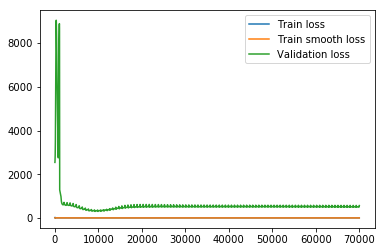

In [25]:
import matplotlib.pyplot as plt

plt.plot(net.losses['train'], label='Train loss')
plt.plot(net.losses['smooth train'], label='Train smooth loss')
plt.plot(net.losses['valid'], label='Validation loss')
plt.legend()
plt.show()

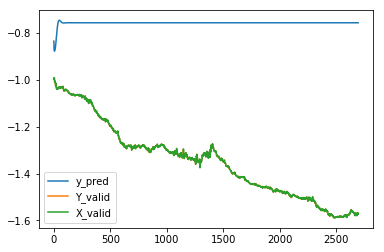

In [26]:
import matplotlib.pyplot as plt

y_pred = net.test(X_seed=X_valid[0], h=net.initial_state(), size=X_valid.shape[0]) # ys_tx1xn
y_pred.shape, Y_valid.shape

plt.plot(y_pred, label='y_pred')
plt.plot(Y_valid, label='Y_valid')
plt.plot(X_valid, label='X_valid')
plt.legend()
plt.show()